# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

**Description:** En esta notebook realizaremos un experimento sobre el *problema del bandido de k brazos* con el que pretendemos comparar el desempeño de distintos algoritmos de la familia *$\varepsilon$-greedy* con el método Softmax, en base a estadísticos como el porcentaje de elecciones de brazo óptimas y el *regret* acumulado en función del tiempo.

Para poder interpretar los resultados, se incluyen unas gráficas con sus respectivos análisis y conclusiones al final de la sección **[2]** y **[3]**.

<br>

*This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.*

*For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html*



## **[1] - Preparación del entorno**


In [1]:
#@title **Copiar el repositorio** ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

Cloning into 'k_brazos_GGM'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 668 (delta 99), reused 16 (delta 16), pack-reused 503 (from 1)
Receiving objects: 100% (668/668), 9.02 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [2]:
#@title **Importamos todas las clases y funciones**

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

from algorithms import Algorithm, EpsilonGreedy, UCB2, Softmax, AdaptiveSoftmax
from arms import ArmNormal, Bandit, ArmBinomial, ArmBernoulli
from plotting import plot_optimal_selections, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **[2] - Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan varios algoritmos $\varepsilon$-greedy con diferentes valores de $\varepsilon$ y UCB2 con diferentes valores de $\alpha$. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualizamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm

### **[2.1] - Ejecución del experimento con Distribución Normal**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 6 algoritmos $\varepsilon$-greedy con $\varepsilon = 0.0, 0.05, 0.1, 0.2, 0.4, 0.7$ y 5 algoritmos Softmax con $\tau = 0.1, 0.5, 1, 3, 6$.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 6 algoritmos epsilon-greedy con diferentes epsilon y 4 algoritmos UCB2 con distintos alpha.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.2), EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7),
             Softmax(k=k, tau = 0.1), Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1), Softmax(k=k, tau = 3), Softmax(k=k, tau = 6)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### **Comparativa del porcentaje de elecciones de brazo óptimas (1)**

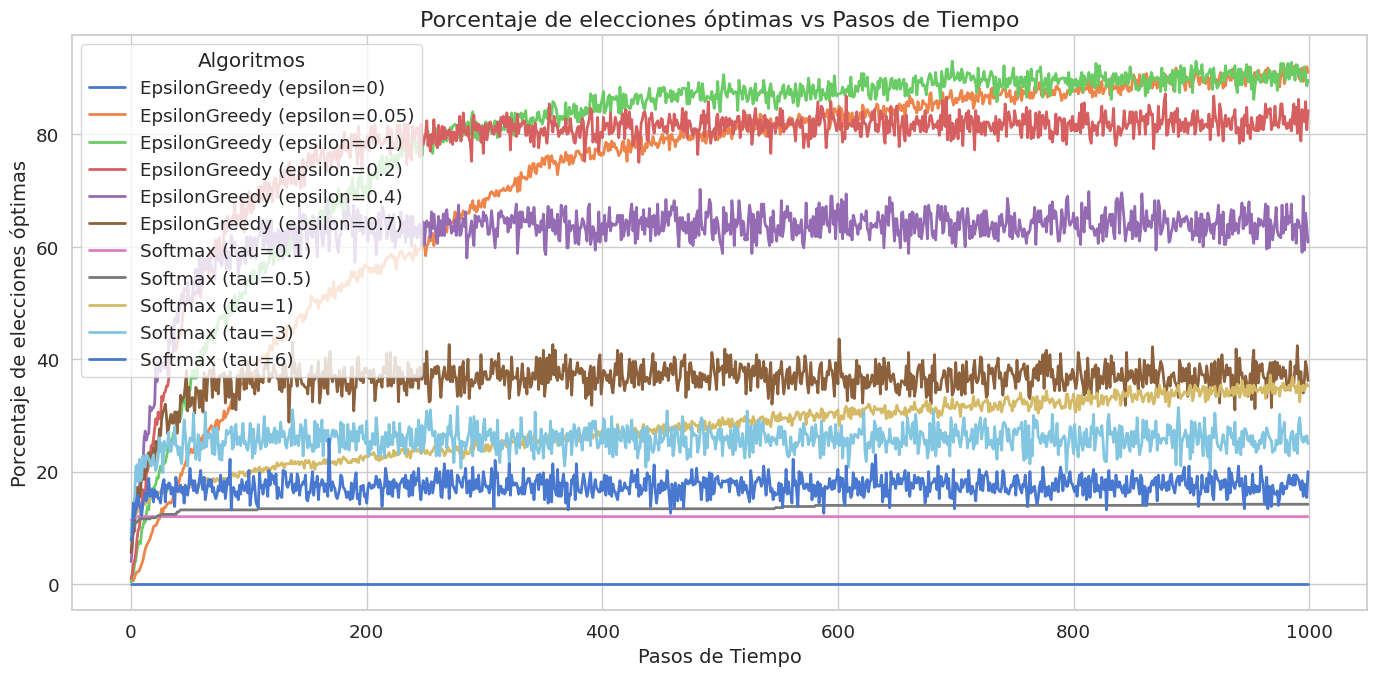

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos Softmax y $\varepsilon$-greedy consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

<br>

Lo más llamativo de este gráfico es la diferencia de desempeño **(a priori)** de cualquier estrategia $\varepsilon$-greedy con respecto a cualquiera de las Softmax. Vemos que para los valores más bajos de $\tau$ (mayor explotación) el método Softmax se comporta muy similar a una estrategia puramente greedy en cuanto a la evolución del porcentaje de elecciones óptimas. Esto se debe a que no hay suficiente exploración y las probabilidades de elección de cada brazo en Softmax se quedan estancadas en una distribución poco favorable de cara a la optimalidad. Sin embargo, al emplear valores altos de $\tau$ (mayores que 1) el algoritmo se vuelve bastante inestable en lo que a elecciones óptimas se refiere, y no superan el 40% en el mejor de los casos ($\tau=1$), lo cual es aún menos que el peor porcentaje de elecciones óptimas de la familia $\varepsilon$-greedy tras las 1000 ejecuciones ($\varepsilon=0.7$).

<br>


Hemos de destacar que la curva del porcentaje de elecciones óptimas de los algoritmos Softmax, tiene su mejor aspecto eligiendo $\tau=1$ pero aún así, el aprendizaje es lento en comparación a un $\varepsilon$-greedy promedio de los que hemos estudiado (salvo para $\tau=1$ como veremos después...).

<br>

Aunque parezca sorprendente, tiene sentido que los metodos Softmax tengan un peor desempeño para este problema que un $\varepsilon$-greedy decentemente ajustado, y esto se debe a que en las elecciones de brazo de Softmax, la recompensa acumulada de cada brazo juega un papel crucial en la asignación de las probabilidaes de elección. Por tanto, si el bandido posee varios brazos *cuasi-óptimos* a parte del brazo óptimo, las probabilidades de elección del brazo óptimo y las de estos brazos van a diferir muy poco, por lo que se repartiría la probabilidad de elección entre ellos. Por ejemplo, si tenemos un brazo óptimo y otro que ofrece recompensas similares (aunque algo menores en promedio), en el mejor de los casos no pasaríamos de un 60% de probabilidad de elección del brazo óptimo aproximadamente. Y este porcentaje decrecería aún más si tuviesemos más brazos *cuasi-óptimos*. Esto hace que la estrategia Softmax *baseline* sea mucho menos robusta que la $\varepsilon$-greedy, y en ocasiones como esta, según las distribuciones de brazos del bandido, podemos presenciar diferencias tan notables entre algoritmos de una y otra clase.

<br>


Para intentar solventar esta problemática podemos utilizar un $\tau$ adaptativo en el tiempo a partir de un valor inicial $\tau_0$. Lo implementamos en la clase ``AdaptiveSoftmax`` y repetimos el experimento.

#### **Repetimos el experimento**

Esta vez probamos con un abanico más grande de opciones paramétricas entre ``Softmax`` y ``AdaptiveSoftmax``, pero nos quedamos con los $\varepsilon$-greedy más "representativos"

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 6 algoritmos epsilon-greedy con diferentes epsilon y 4 algoritmos UCB2 con distintos alpha.
algorithms = [EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7),
              Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1), Softmax(k=k, tau = 3),
              AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.00001)]


# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### **Comparativa del porcentaje de elecciones de brazo óptimas (2)**

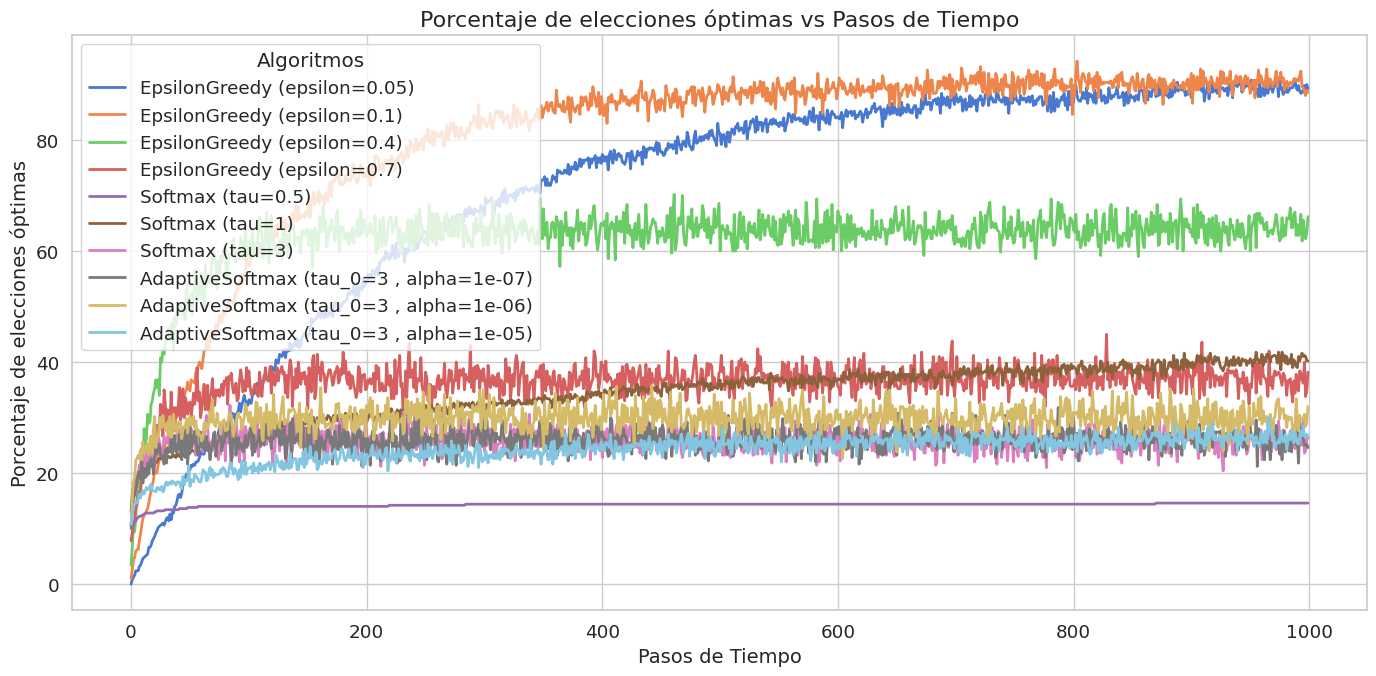

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Los resultados con el Softmax adaptativo no han mejorado los del softmax estándar con $\tau=1$ en lo que a elecciones de brazo óptimo se refiere, así que podemos concluir que en general, los algoritmos de Softmax pueden llegar en ocasiones a funcionar mucho peor que los $\epsilon$-greedy para este problema; por el motivo que comentábamos antes de los brazos *cuasi-óptimos*.

#### **Comparativa del regret acumulado**

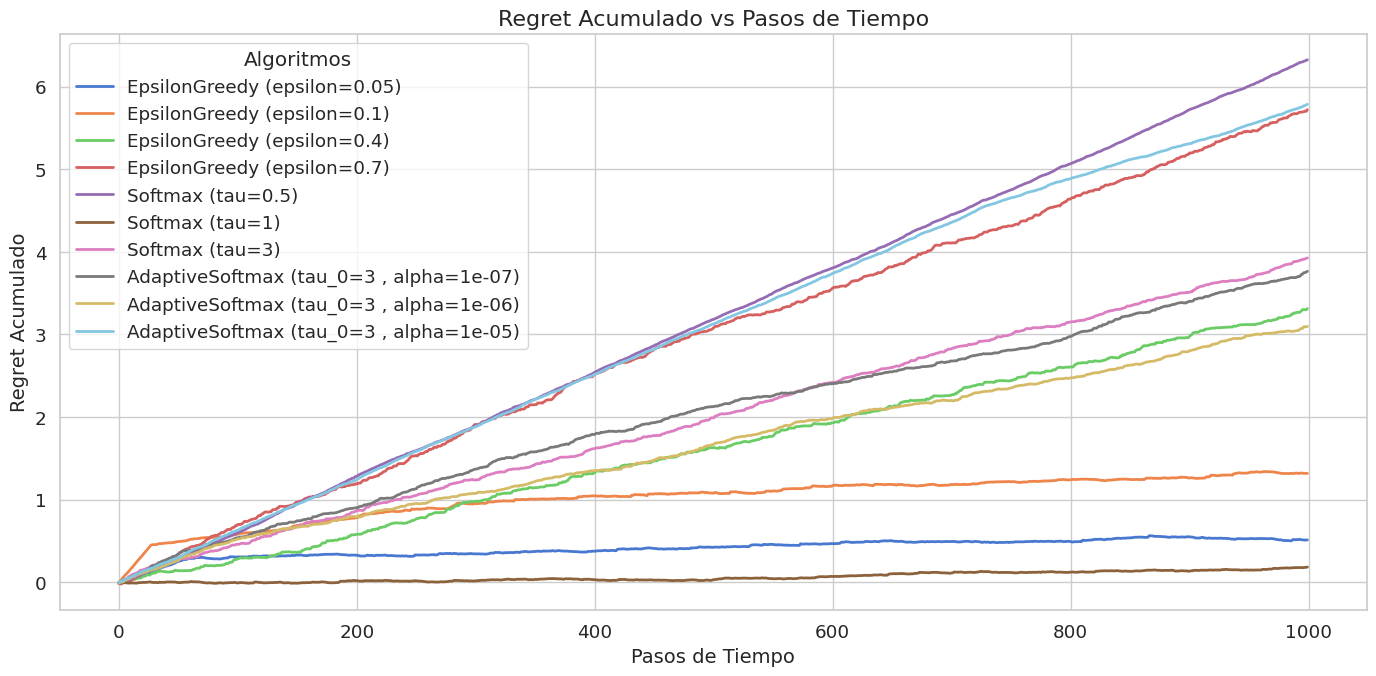

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB2** y **$\varepsilon$-greedy** considerado.

<br>

La gran sorpresa al analizar esta gráfica es que el menor regret proviene del algoritmo Softmax con $\tau=1$. De esto deducimos que a pesar de no seleccionas más de un 40% de las veces el brazo óptimo, realiza elecciones sub-óptimas con bastante *buen criterio* y que en casos concretos (sobre todo si el número de episodios generado no es muy grande) puede proporcionar retornos mejores que la estrategia $\varepsilon$-greedy mejor ajustada (en este caso, con $\varepsilon = 0.05$). Sin embargo, en la gráfica vemos que a aprtir de 500 episodios, el regret acumulado de Softmax($\tau=1$) va aumentando ligeramente, menos de lo que lo hace el de $\varepsilon$-greedy($\varepsilon=0.05$). Sospechamos que a la larga, el mayor porcentaje de elecciones de brazo óptimo que presenta este $\varepsilon$-greedy, acabará por dominar el *buen criterio* de este algoritmo Softmax.

Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \frac{(\mu_i - \mu^*)^2}{2\sigma^2}$

In [ ]:
def I_normal(mu_i, mu_star, sigma_2):
    """Divergencia KL entre dos normales con la misma varianza."""
    return (mu_i - mu_star)**2 / (2 * sigma_2)

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
sigma_2 = 1          # Varianza de los brazos (igual para todos)

# Calcular la constante
cte = sum((mu_star - mu) / I_normal(mu, mu_star, sigma_2) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-16-e8a6397acd45>:13: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


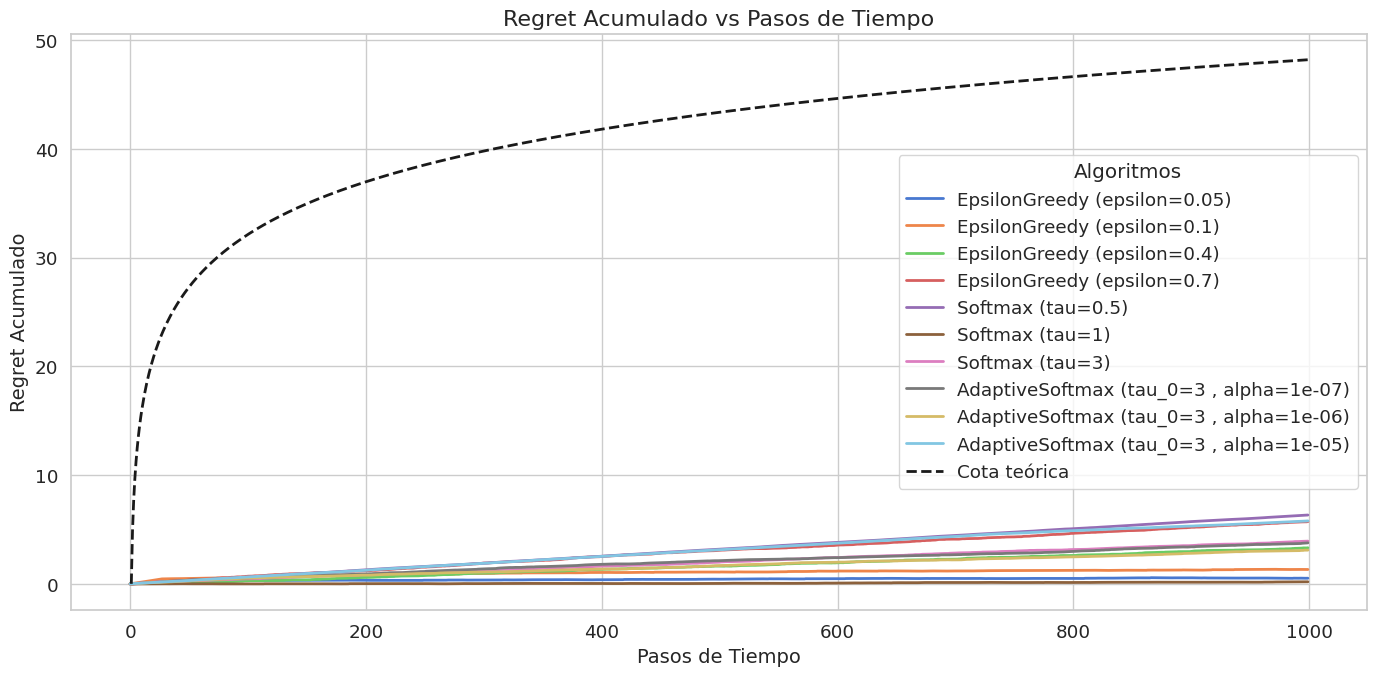

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

Efectivamente, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos considerados, mostrando el buen desempeño en particular del grupo de algoritmos con menor regret.

### **[2.2] - Ejecución del experimento con Distribución Bernoulli**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 4 algoritmos $\varepsilon$-greedy con 6 algoritmos Softmax.

In [4]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k))    # Generar un bandido con k brazos de distribución Bernoulli
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 6 algoritmos epsilon-greedy con diferentes epsilon y 4 algoritmos UCB2 con distintos alpha.
algorithms = [EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7),
              Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1), Softmax(k=k, tau = 3),
              AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.00001)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBernoulli(p=0.3745401188473625), ArmBernoulli(p=0.9507143064099162), ArmBernoulli(p=0.7319939418114051), ArmBernoulli(p=0.5986584841970366), ArmBernoulli(p=0.15601864044243652), ArmBernoulli(p=0.15599452033620265), ArmBernoulli(p=0.05808361216819946), ArmBernoulli(p=0.8661761457749352), ArmBernoulli(p=0.6011150117432088), ArmBernoulli(p=0.7080725777960455)
Optimal arm: 2 with expected reward=0.9507143064099162


#### **Comparativa del porcentaje de elecciones de brazo óptimas**

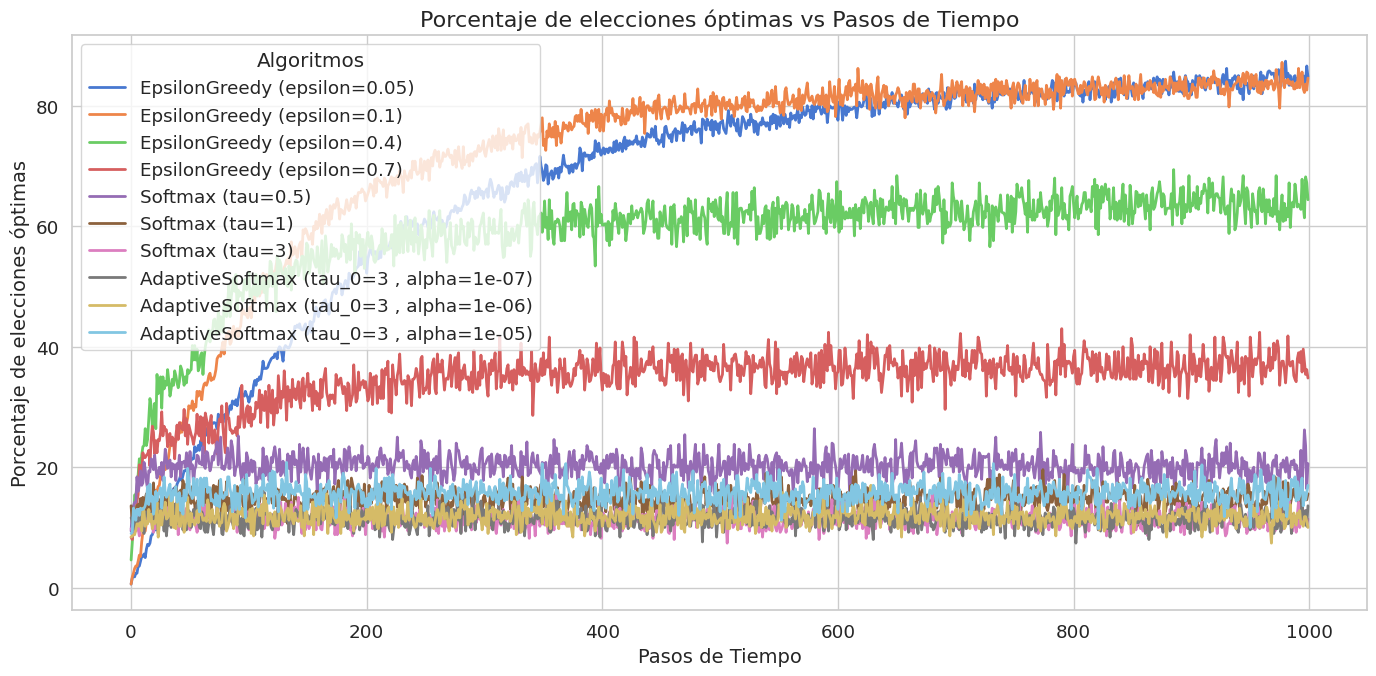

In [5]:
plot_optimal_selections(steps, optimal_selections, algorithms)


En general, los porcentajes de selección de brazo óptimo no varían a penas entre los algoritmos de la familia $\varepsilon$-greedy al pasar de distribución normal a distribución bernoulli en los brazos del bandido. Sin embargo, si que hay diferencias significativas en esta medida para  los algoritmos Softmax (tanto adaptativos como estándar).

<br>

Por ejemplo, el porcentaje para Softmax estándar de $\tau=0.5$ sube hasta el 20% desde un 15%, y Softmax($\tau=1$) baja de 40% a 17%. También los Softmax adaptativos que estaban entre 20 y 40% bajan por debajo de 20% en este caso.

Con esto podemos comprobar cómo los métodos Softmax son más sensibles al cambio de distribuciones que los metodos $\varepsilon$-greedy, en lo que a elecciones de brazo óptimo se refiere. Veamos si hay diferencias en cuanto al regret acumulado:

#### **Comparativa del regret acumulado**

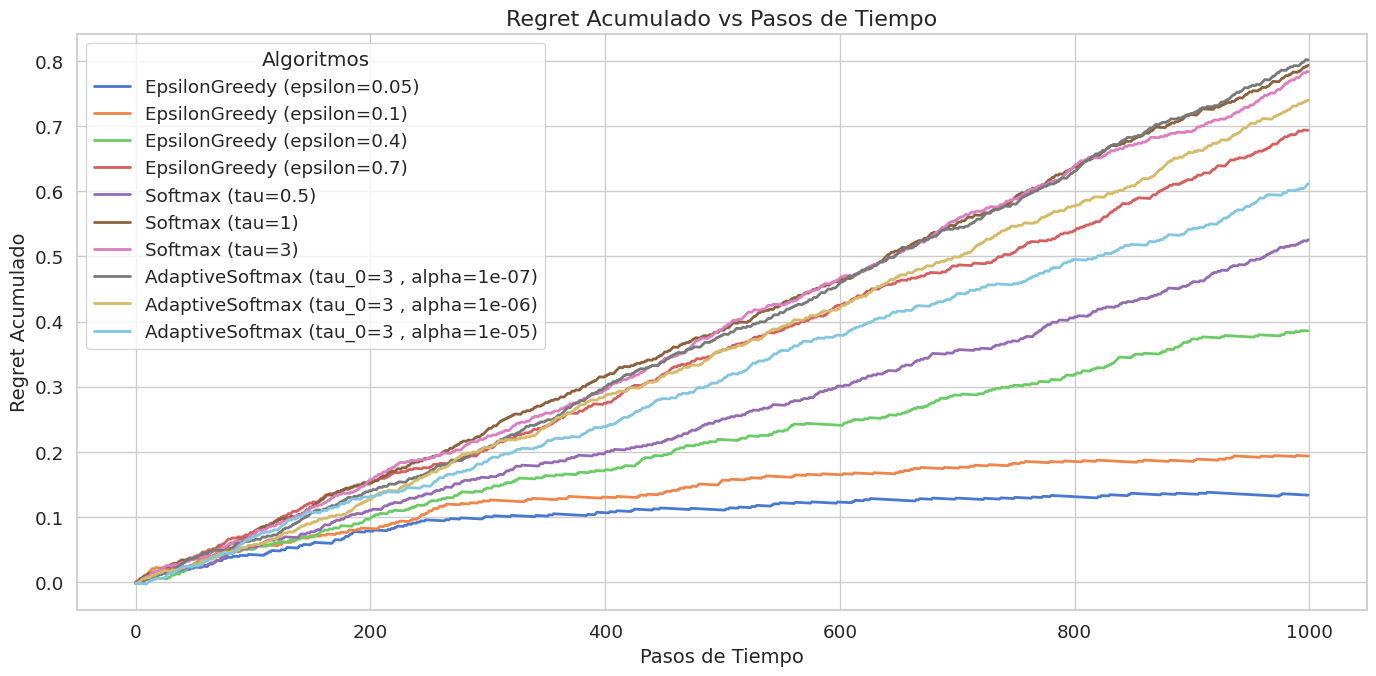

In [6]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

Al analizar la gráfica de regret acumulado para los distintos algoritmos, vemos que con brazos Bernoulli, el claro ganador de este experimento es el $\varepsilon$-greedy de parámetro $0.05$. Pero además, todos los algoritmos de esta familia presentan menor regret que los Softmax estudiados. De hecho el mejor Softmax ene ste experimento es Softmax($\tau=0.5$) (línea morada) y su valor de regret acumulado es aproximadamente el promedio del de todos los algoritmos ejecutados. Así que comparativamente, estos algoritmos lo hacen mucho peor en este caso.

Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \mu_i \ln \left( \frac{\mu_i}{\mu^*} \right) + (1 - \mu_i) \ln \left( \frac{1 - \mu_i}{1 - \mu^*} \right)$

In [7]:
def I_bernoulli(mu_i, mu_star):
    """Divergencia KL entre dos Bernoulli."""
    return mu_i * np.log(mu_i / mu_star) + (1 - mu_i) * np.log((1 - mu_i) / (1 - mu_star))

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo

# Calcular la constante
cte = sum((mu_star - mu) / I_bernoulli(mu, mu_star) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-7-14c133996bdd>:12: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


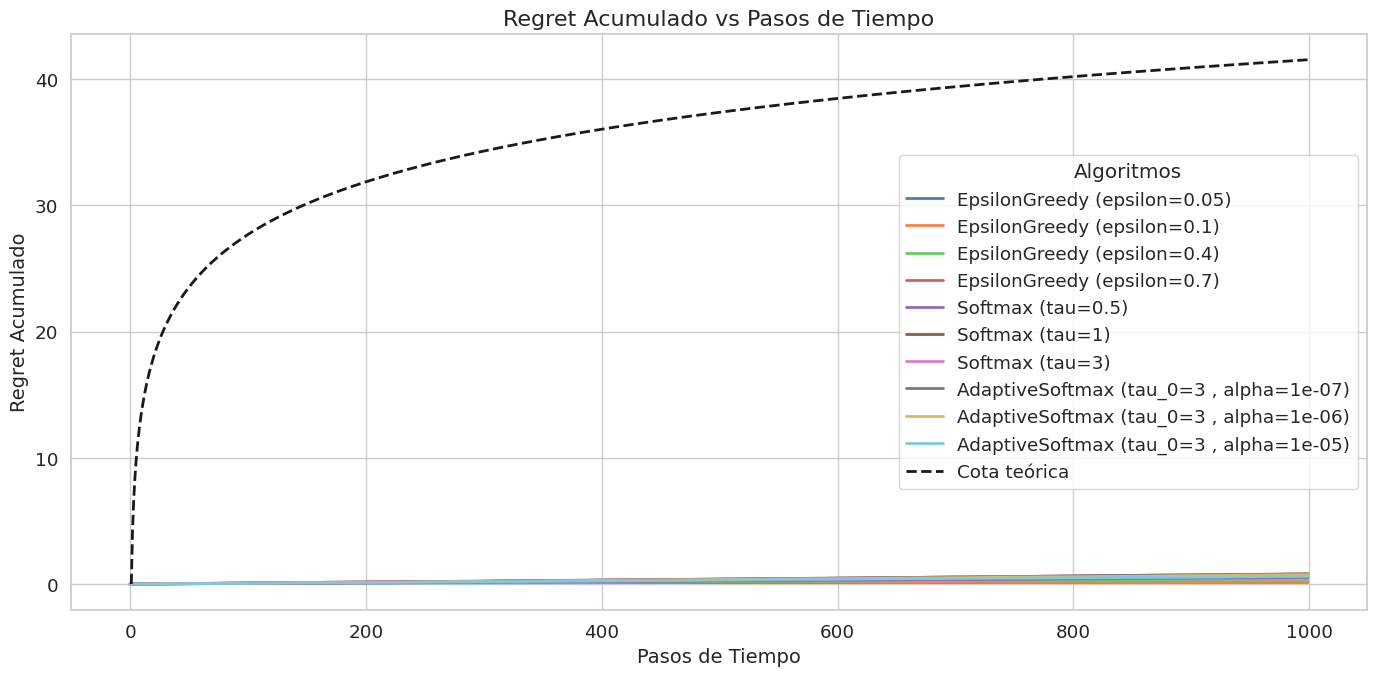

In [8]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

De nuevo, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos.

### **[2.3] - Ejecución del experimento con Distribución Binomial**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 6 algoritmos $\varepsilon$-greedy con $\varepsilon = 0.0, 0.05, 0.1, 0.2, 0.4, 0.7$ y 4 algoritmos UCB2 con $\alpha = 0.1, 0.3, 0.5, 0.9$.

In [9]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k))    # Generar un bandido con k brazos de distribución Binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 6 algoritmos epsilon-greedy con diferentes epsilon y 4 algoritmos UCB2 con distintos alpha.
algorithms = [EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7),
              Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1), Softmax(k=k, tau = 3),
              AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 3, alpha=0.00001)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBinomial(n=20, p=0.21233911067827616), ArmBinomial(n=2, p=0.8661761457749352), ArmBinomial(n=9, p=0.9507143064099162), ArmBinomial(n=8, p=0.5247564316322378), ArmBinomial(n=5, p=0.18340450985343382), ArmBinomial(n=15, p=0.7080725777960455), ArmBinomial(n=1, p=0.9699098521619943), ArmBinomial(n=11, p=0.2912291401980419), ArmBinomial(n=18, p=0.5986584841970366), ArmBinomial(n=4, p=0.15599452033620265)
Optimal arm: 9 with expected reward=10.775852715546659


#### **Comparativa del porcentaje de elecciones de brazo óptimas**

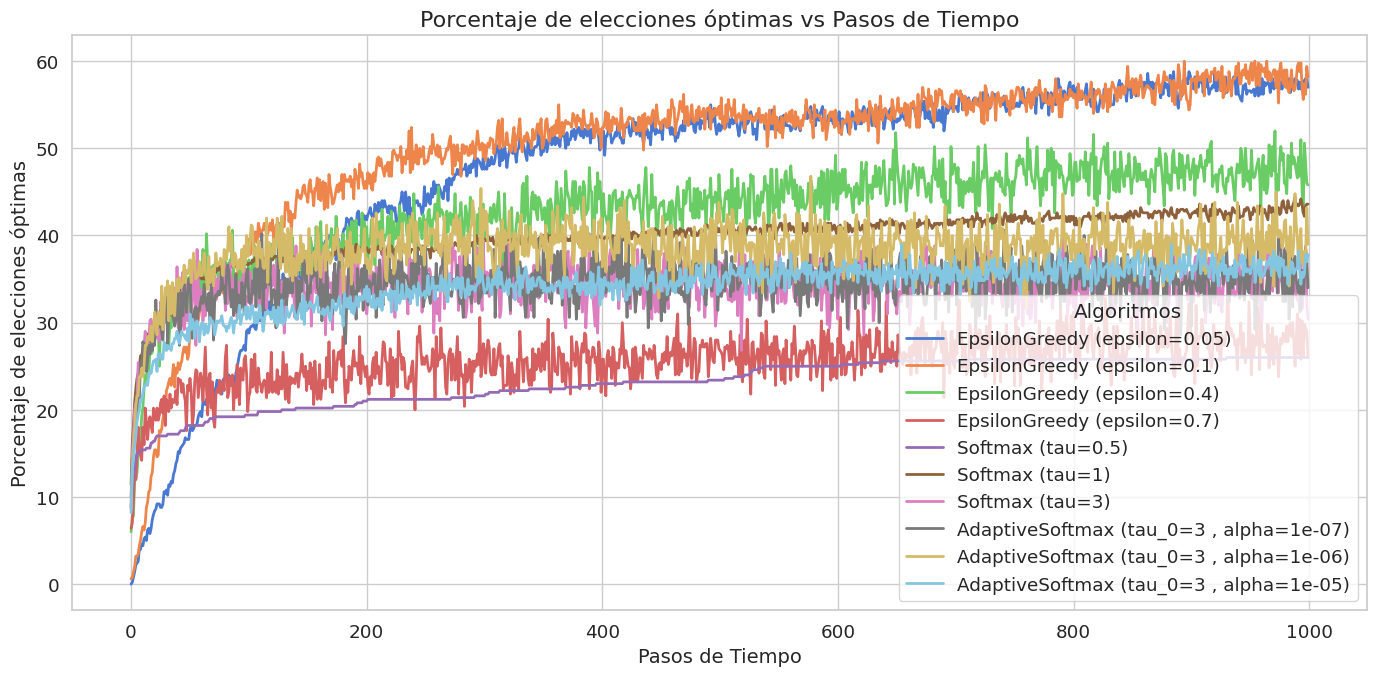

In [10]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Con esta imagen podemos volvemos a validar que la distribución de los brazos del bandido afecta notablemente a la medida del porcentaje de elecciones óptimas, pues ahora, incluso los algoritmos $\varepsilon$-greedy se ven afectados. Los mejores de acuerdo a esta métrica vuelven a ser $\varepsilon = 0.05 , 0.1$ empatando, pero con tan solo un 60% de elecciones óptimas. Los métodos Softmax se ubican ahora entre 25% y 40% (mejoran ligeramente) pero aún siguen por debajo de todos los algoritmos $\varepsilon$-greedy salvo $\varepsilon = 0.7$ que apenas llega al 30% esta vez.

#### **Comparativa del regret acumulado**

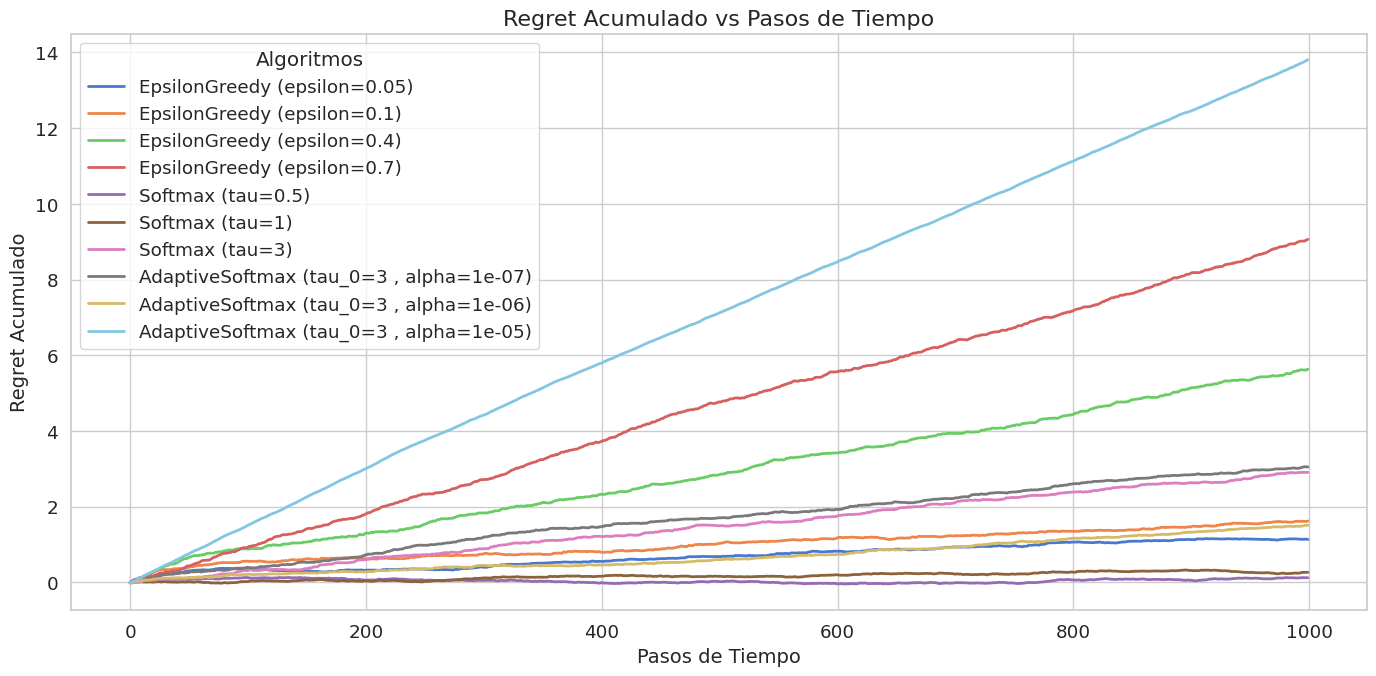

In [11]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

Al analizar el regret acumulado nos volvemos a llevar una sorpresa, pues ahora, los algoritmos que menos regret acumulan pasan a ser Softmax($\tau = 0.5$) y Softmax($\tau = 1$), destronando con claridad a los algoritmos $\varepsilon$-greedy que mejor resultado ofrecen.

## **[3] - Conclusiones de este estudio**

Mejores resultados según el estadístico seleccionado y según la distribución elegida para los brazos

| Distribución de los brazos | Porcentaje de elecciones de brazo óptimas en el último paso | Regret acumulado en el último paso |
|:---------:|:---------:|:---------:|
| Normal  | ($\varepsilon=0.1$), ($\varepsilon=0.05$)  | Softmax($\tau=1$) , ($\varepsilon=0.05$)  |
| Bernoulli  | ($\varepsilon=0.1$) , ($\varepsilon=0.05$)  | ($\varepsilon=0.1$) , ($\varepsilon=0.05$)  |
| Binomial  | ($\varepsilon=0.1$), ($\varepsilon=0.05$)   | Softmax($\tau=0.5$) , Softmax($\tau=1$) |




Como conclusión podemos determinar que al cambiar la distribución de los brazos del bandido, el algoritmo que mejor desempeño ofrece también cambia. otro dato curioso es que no necesariamente por tener mejor porcentaje de decisiones de brazo óptimo se consigue en la práctica un menor regret acumulado.

También podemos decir que hay un top claro de algoritmos, que son los 4 que aparecen en la tabla, de entre todos los que hemos analizado. Sin embargo, según las distribuciones de los brazos, unos darán mejor resultado que otros de entre estos 4.

Un motivo para justificar el mejo desempeño de los $\varepsilon$-greedy en el caso de los brazos de distribución normal, es que todos los brazos normales tienen varianza 1, mientras que los brazos de los otros bandidos tienen varianzas distintas. El escenario de varianza idéntica para todos los brazos resulta favorable para un algoritmo $\varepsilon$-greedy porque en ese caso, el rasgo más discriminante para elegir brazo pasa a ser la media de la distribución, que justamente es en lo que nos basamos para elgir un brazo óptimo y de hecho hace que el brazo teóricamente óptimo resulte "más óptimo en la práctica".


Por su parte, la vertiente exploratoria de los algoritmos Softmax tienen una política de elección de brazo más acertada por naturaleza que la de los $\varepsilon$-greedy, que simplemente eligen un brazo no-óptimo al azar. Por esto, realizan elecciones de brazo más acertadas de forma global en bandidos con distribuciones de gran varianza o con varianzas distintas.

